<a href="https://colab.research.google.com/github/simulate111/Data-Science_2024/blob/main/Mini%20Project%201%20%E2%80%93%20What%20should%20I%20cook%20tonight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from IPython.display import display, HTML

In [38]:
def scrape_recipe_details(link):
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(link, headers=headers, timeout=10)
    soup = BeautifulSoup(response.text, 'html.parser')
    title = soup.select_one('.entry-title')
    ww_points = soup.select_one('.recipe-meta-value.recipe-ww-pp')

    recipe_titles = soup.select('ul.cat-icons.post-icons a')
    recipe_keys_list = [key['title'] for key in recipe_titles if 'title' in key.attrs]

    calories_container = soup.select_one('.wprm-nutrition-label-text-nutrition-container-calories')
    calories_value = (calories_container.select_one('.wprm-nutrition-label-text-nutrition-value').get_text(strip=True) if calories_container else "N/A")
    calories_value = int(calories_value) if calories_value.isdigit() else None
    title = title.get_text(strip=True) if title else "N/A"
    image = soup.find('img', {'decoding': 'async', 'fetchpriority': 'high'})
    image_src = image['src'] if image else "N/A"
    points_value = (ww_points.get_text(strip=True) if ww_points else "N/A")
    points_value = int(points_value) if points_value.isdigit() else None
    return {'Food': title, 'Image': image_src, 'Calories': calories_value, 'Points': points_value, 'Recipe Keys': recipe_keys_list}


def scrapes(start_page, end_page):
    all_recipes = []
    base_url = 'https://www.skinnytaste.com/recipe-index/?_paged={}'
    for page in tqdm(range(start_page, end_page + 1), bar_format='{bar}| {n_fmt}/{total_fmt} pages', leave=False):
        url = base_url.format(page)
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        recipe_links = [a['href'] for a in soup.select('.entry-title a')]
        for link in recipe_links:
            recipe_details = scrape_recipe_details(link)
            if recipe_details:
                all_recipes.append(recipe_details)

    # Remove N/A
    filtered_recipes = [recipe for recipe in all_recipes if recipe['Calories'] is not None and recipe['Points'] is not None]

    return filtered_recipes

In [39]:
# Scrape the first xx pages
recipes = scrapes(1, 51)

In [40]:
df = pd.DataFrame(recipes)
display(df)

,Food,Image,Calories,Points,Recipe Keys
0,Apple Butter,https://www.skinnytaste.com/wp-content/uploads...,34,1,"[Dairy Free Recipes, Gluten Free, Kid Friendly..."
1,Roasted Delicata Squash,https://www.skinnytaste.com/wp-content/uploads...,177,4,"[Dairy Free Recipes, Gluten Free, Vegetarian M..."
2,Apple Bread,https://www.skinnytaste.com/wp-content/uploads...,124,4,[Vegetarian Meals]
3,Autumn Salad with Pears and Gorgonzola,https://www.skinnytaste.com/wp-content/uploads...,175,5,"[Gluten Free, Low Carb, Under 30 Minutes, Vege..."
4,Sesame Chicken,https://www.skinnytaste.com/wp-content/uploads...,513,9,"[Dairy Free Recipes, Freezer Meals, Gluten Fre..."
5,Bacon in the Oven,https://www.skinnytaste.com/wp-content/uploads...,60,2,"[Dairy Free Recipes, Gluten Free, High Protein..."
6,Pumpkin Spice Latte,https://www.skinnytaste.com/wp-content/uploads...,115,7,"[Dairy Free Recipes, Gluten Free, Vegetarian M..."
7,Homemade Hamburger Helper,https://www.skinnytaste.com/wp-content/uploads...,453,12,"[Dairy Free Recipes, Gluten Free, High Protein..."
8,Fried Brown Rice,https://www.skinnytaste.com/wp-content/uploads...,276,6,"[Dairy Free Recipes, Gluten Free, High-Fiber R..."
9,Sweet Potato Salad,https://www.skinnytaste.com/wp-content/uploads...,290,8,"[Dairy Free Recipes, Gluten Free, High-Fiber R..."


Text(0, 0.5, 'Count')

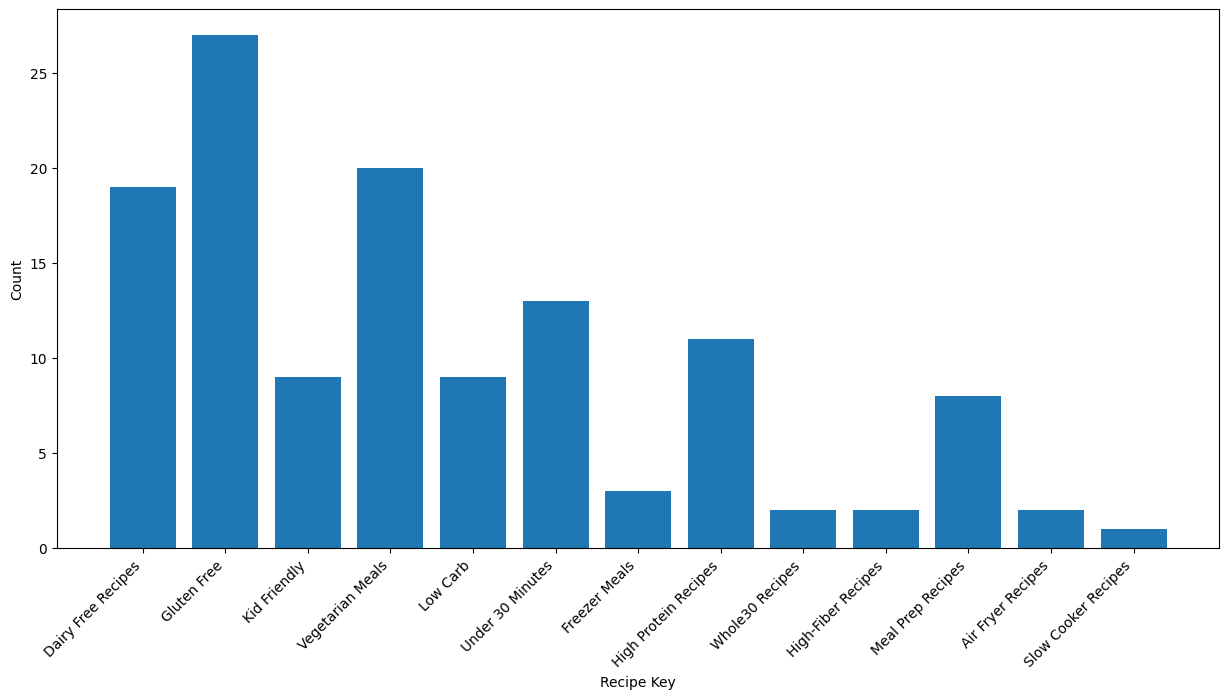

In [41]:
all_recipe_keys = [key for sublist in df['Recipe Keys'] for key in sublist]
key_counts = Counter(all_recipe_keys)
key_counts_df = pd.DataFrame(key_counts.items(), columns=['Recipe Key', 'Count'])
plt.figure(figsize=(15, 7))
plt.bar(key_counts_df['Recipe Key'], key_counts_df['Count'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Recipe Key')
plt.ylabel('Count')

Text(0, 0.5, 'Frequency')

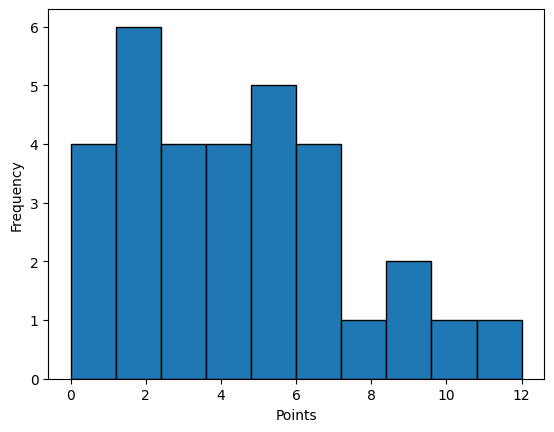

In [42]:
plt.hist(df['Points'], bins=10, edgecolor='black')
plt.xlabel('Points')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

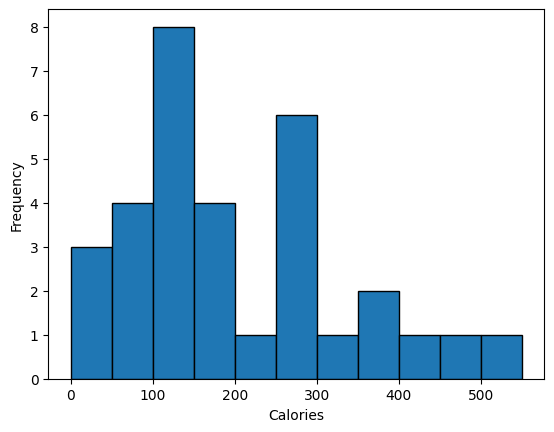

In [43]:
plt.hist(df['Calories'], bins=range(0, int(df['Calories'].max()) + 50, 50), edgecolor='black')
plt.xlabel('Calories')
plt.ylabel('Frequency')

In [44]:
def filters(df):
    max_points = df['Points'].max()
    min_points = df['Points'].min()
    max_calories = df['Calories'].max()
    min_calories = df['Calories'].min()
    print(f"Maximum Points: {max_points}")
    print(f"Minimum Points: {min_points}")
    print(f"Maximum Calories: {max_calories}")
    print(f"Minimum Calories: {min_calories}")
    print("Which range of calories and points do you like to be suggested?")

    calorie_min = int(input("Enter minimum calories: "))
    calorie_max = int(input("Enter maximum calories: "))
    point_min = int(input("Enter minimum points: "))
    point_max = int(input("Enter maximum points: "))
    filtered_df = df[(df['Calories'] >= calorie_min) & (df['Calories'] <= calorie_max) & (df['Points'] >= point_min) & (df['Points'] <= point_max)]

    # Sort by calories
    sorted_recipes = filtered_df.sort_values(by='Calories').head(10).reset_index(drop=True)
    if not sorted_recipes.empty:
        # Check for image link validity
        if 'Image' in sorted_recipes.columns:
            def format_image(image_link):
                if pd.notna(image_link) and image_link.strip():
                    return f'<img src="{image_link}" width="150" />'
                return ''

            sorted_recipes['Image'] = sorted_recipes['Image'].apply(format_image)
        display(HTML(sorted_recipes[['Food', 'Calories', 'Points', 'Image', 'Recipe Keys']].to_html(escape=False)))
    else:
        print("No recipes found in the specified range.")

filters(df)

Maximum Points: 12
Minimum Points: 0
Maximum Calories: 513
Minimum Calories: 13
Which range of calories and points do you like to be suggested?
Enter minimum calories: 22
Enter maximum calories: 222
Enter minimum points: 2
Enter maximum points: 5


,Food,Calories,Points,Image,Recipe Keys
0,Bacon in the Oven,60,2,,"[Dairy Free Recipes, Gluten Free, High Protein Recipes, Kid Friendly, Low Carb, Under 30 Minutes, Whole30 Recipes]"
1,Strawberry Yogurt Bark,60,2,,"[Dairy Free Recipes, Gluten Free, Kid Friendly, Vegetarian Meals]"
2,Watermelon Feta Salad,85,2,,"[Gluten Free, Under 30 Minutes, Vegetarian Meals]"
3,Broccoli Cauliflower Salad,97,2,,"[Dairy Free Recipes, Gluten Free, Low Carb, Meal Prep Recipes, Under 30 Minutes, Vegetarian Meals]"
4,Coconut Popsicles,106,5,,"[Gluten Free, Kid Friendly]"
5,Grilled Eggplant with Feta,106,3,,"[Gluten Free, Low Carb, Under 30 Minutes, Vegetarian Meals]"
6,Blueberry Zucchini Bread,111,4,,"[Freezer Meals, Kid Friendly, Vegetarian Meals]"
7,Ratatouille,115,2,,"[Dairy Free Recipes, Gluten Free, Meal Prep Recipes, Vegetarian Meals]"
8,Lemon Vinaigrette,123,5,,"[Dairy Free Recipes, Gluten Free, Low Carb, Meal Prep Recipes, Under 30 Minutes, Vegetarian Meals]"
9,Apple Bread,124,4,,[Vegetarian Meals]
